In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import get_act_name
from transformers import GPTNeoXForCausalLM, AutoTokenizer, AutoModelForCausalLM
from jaxtyping import Float, Int
from typing import List, Optional, Tuple, Dict
import sys
from functools import partial
from tqdm import tqdm
import json
import seaborn as sns
import pandas as pd

from activations import get_residual_stream_activations, get_layers_to_enumerate, apply_activation_patch, request_patching
from plots import plot_request_patching_normalized_accuracy

import warnings
#warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =', device)
torch.set_grad_enabled(False)

# List all available GPUs
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

else:
    print("CUDA is not available. Listing CPUs instead.")
    print(torch.__version__)

/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = cpu
CUDA is not available. Listing CPUs instead.
2.2.0+cu121


Number of stories: 5
Number of requests: 2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

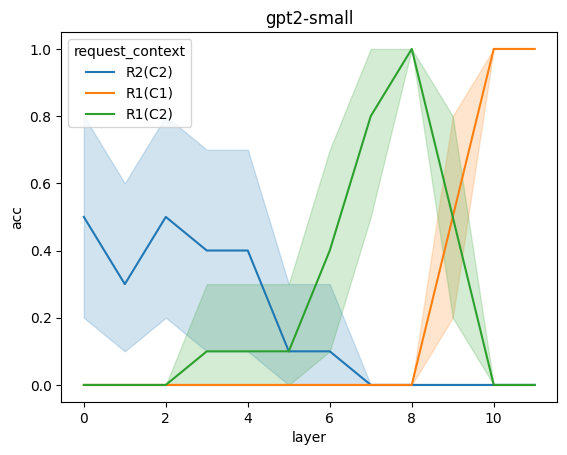

In [3]:
warnings.filterwarnings('ignore')
fig = plot_request_patching_normalized_accuracy(model_name='gpt2-small',
                                                savefig=True)

Number of stories: 5
Number of requests: 2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

AttributeError: 'list' object has no attribute 'savefig'

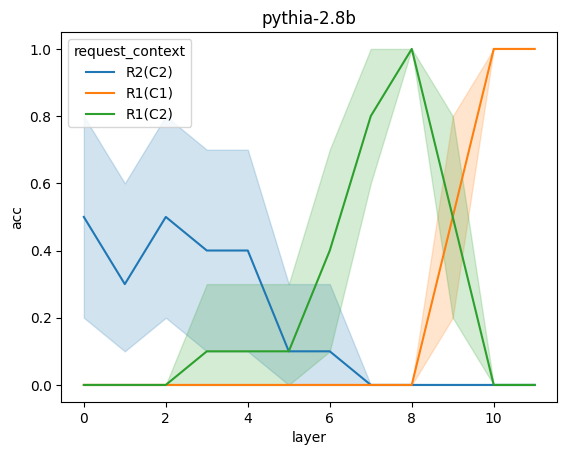

In [5]:
fig = plot_request_patching_normalized_accuracy(model_name='pythia-2.8b',
                                                savefig=True)

## Tests

In [2]:
# Alice
story_1 = '''Here is a short story. Read it carefully and answer the questions below with a keyword 
from the text.

Alice was a young woman with a keen sense of adventure, living in the heart of London.
Her life was a blend of the modern hustle and the city's age-old mysteries, nestled within the winding 
streets and historic buildings of her neighborhood. Alice worked at a small, independent bookstore 
nestled between towering skyscrapers and ancient pubs, a place that seemed to resist the passage of time.
It was her sanctuary, filled with the scent of old books and the quiet 
whispers of stories waiting to be discovered. Despite her love for the quiet life, Alice couldn't shake 
off the feeling that there was something more, a deeper mystery that lay hidden beneath the surface of 
her daily existence. It was a feeling that would soon lead her on an unexpected journey.

Answer the question below.

Question: Where is the story?

Answer: In the city of'''

# Bob
story_2 = '''Here is a short story. Read it carefully and answer the questions below with a keyword 
from the text.

Bob is an artist through and through, whose spirit and creativity are as vibrant and lively 
as the city of Paris itself. He resides in a charming, light-filled studio apartment in Montmartre, 
surrounded by the echoes of the great artists who once roamed its cobblestone streets. Bob's days are 
spent wandering the city with his sketchbook in hand, capturing the essence of Parisian life—the bustling 
cafés, the serene parks, the historic bridges over the Seine—with quick, deft strokes of his pencil.
By night, his small studio transforms into a hive of artistic activity. Canvases of all sizes lean against 
the aged plaster walls, each one a testament to Bob's love for the city and its endless inspiration.

Answer the question below.

Question: Who is in the story?

Answer: The character is'''

In [44]:
model, tokenizer = get_model_from_name('pythia-2.8b')
layers = len(get_layers_to_enumerate(model))

activations = get_residual_stream_activations(model,
                                              tokenizer,
                                              story_1)


for layer in range(layers):
    tokens = apply_activation_patch(model=model,
                                    tokenizer=tokenizer,
                                    target_prompt=story_2,
                                    target_layer_idx=layer,
                                    source_activations=activations)

    str_tokens = tokenizer.batch_decode(tokens)
    last_str_token = str_tokens[-1].split()[-1] #corriger
    print(f'Layer {layer} - {last_str_token}')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 217, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 0 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 1 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 2 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 3 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 4 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 5 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 6 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 7 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 8 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 9 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 10 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 11 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 12 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 13 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 14 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 15 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 16 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 17 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 18 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 19 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 20 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 21 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 22 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 23 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 24 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 25 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 26 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 27 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 28 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 29 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 30 - London
Layer 31 - London


In [48]:
model, tokenizer = get_model_from_name('pythia-2.8b')
layers = len(get_layers_to_enumerate(model))

activations = get_residual_stream_activations(model,
                                              tokenizer,
                                              story_2)


for layer in range(layers):
    tokens = apply_activation_patch(model=model,
                                    tokenizer=tokenizer,
                                    target_prompt=story_1,
                                    target_layer_idx=layer,
                                    source_activations=activations)

    str_tokens = tokenizer.batch_decode(tokens)
    last_str_token = str_tokens[-1].split()[-1] #corriger
    print(f'Layer {layer} - {last_str_token}')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 229, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 0 - the


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 1 - the


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 2 - the


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 3 - the


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 4 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 5 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 6 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 7 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 8 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 9 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 10 - in


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 11 - in


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 12 - in


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 13 - in


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 14 - Alice


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 15 - Alice


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 16 - Alice


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 17 - Alice


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 18 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 19 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 20 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 21 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 22 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 23 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 24 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 25 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 26 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 27 - a


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 28 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 29 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 30 - Bob
Layer 31 - Bob


In [4]:
model, tokenizer = get_model_from_name('gpt2-small')
layers = len(get_layers_to_enumerate(model))

activations = get_residual_stream_activations(model,
                                              tokenizer,
                                              story_1)


for layer in range(layers):
    tokens = apply_activation_patch(model=model,
                                    tokenizer=tokenizer,
                                    target_prompt=story_2,
                                    target_layer_idx=layer,
                                    source_activations=activations)

    str_tokens = tokenizer.batch_decode(tokens)
    last_str_token = str_tokens[-1].split()[-1] #corriger
    print(f'Layer {layer} - {last_str_token}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 0 - Bob


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 1 - Bob


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 2 - the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 3 - Paris


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 4 - Paris


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 5 - Paris


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 6 - Paris


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 7 - Paris


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 8 - Paris


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 9 - Paris


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Layer 10 - London
Layer 11 - London


In [4]:
def request_patch_all_prompt_pairs(model_name: str,
                                   all_prompt_pairs
):    
    model, tokenizer = get_model_from_name('gpt2-small')
    layers = len(get_layers_to_enumerate(model))
    tokens_per_prompt_pair = []

    for context_1, context_2 in all_prompt_pairs:
        print('ctx1', context_1)
        print('ctx2', context_2)

        activations = get_residual_stream_activations(model,
                                                      tokenizer,
                                                      context_1)

        token_per_layer = []
        for layer in range(layers):
            tokens = apply_activation_patch(model=model,
                                            tokenizer=tokenizer,
                                            target_prompt=context_2,
                                            target_layer_idx=layer,
                                            source_activations=activations)

            str_tokens = tokenizer.batch_decode(tokens)
            last_str_token = str_tokens[-1].split()[-1]
            token_per_layer.append(last_str_token)
        print(token_per_layer)
        tokens_per_prompt_pair.append(token_per_layer)

    return tokens_per_prompt_pair 
     

tokens_per_prompt_pair = request_patch_all_prompt_pairs(model_name='gpt2-small',
                               all_prompt_pairs=all_prompt_pairs)

ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Alice was a young woman with a keen sense of adventure, living in the heart of London. Her life was a blend of the modern hustle and the city's age-old mysteries, nestled within the winding streets and historic buildings of her neighborhood. Alice worked at a small, independent bookstore nestled between towering skyscrapers and ancient pubs, a place that seemed to resist the passage of time. It was her sanctuary, filled with the scent of old books and the quiet whispers of stories waiting to be discovered. Despite her love for the quiet life, Alice couldn't shake off the feeling that there was something more, a deeper mystery that lay hidden beneath the surface of her daily existence. It was a feeling that would soon lead her on an unexpected journey.

Answer the question below.

Question: Where is the story?
Answer: In the city of
ctx2 Here is a short story. Read it carefully an

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 195, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 

['Bob', 'Bob', 'Bob', 'Paris', 'Paris', 'Paris', 'Paris', 'Paris', 'Paris', 'London', 'London', 'London']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Alice was a young woman with a keen sense of adventure, living in the heart of London. Her life was a blend of the modern hustle and the city's age-old mysteries, nestled within the winding streets and historic buildings of her neighborhood. Alice worked at a small, independent bookstore nestled between towering skyscrapers and ancient pubs, a place that seemed to resist the passage of time. It was her sanctuary, filled with the scent of old books and the quiet whispers of stories waiting to be discovered. Despite her love for the quiet life, Alice couldn't shake off the feeling that there was something more, a deeper mystery that lay hidden beneath the surface of her daily existence. It was a feeling that would soon lead her on an unexpected journey.

Answer the question bel

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 236, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end genera

['Clara', 'Clara', 'Clara', 'Clara', 'Clara', 'Cl', 'Cl', 'Edinburgh', 'Edinburgh', 'Edinburgh', 'London', 'London']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Alice was a young woman with a keen sense of adventure, living in the heart of London. Her life was a blend of the modern hustle and the city's age-old mysteries, nestled within the winding streets and historic buildings of her neighborhood. Alice worked at a small, independent bookstore nestled between towering skyscrapers and ancient pubs, a place that seemed to resist the passage of time. It was her sanctuary, filled with the scent of old books and the quiet whispers of stories waiting to be discovered. Despite her love for the quiet life, Alice couldn't shake off the feeling that there was something more, a deeper mystery that lay hidden beneath the surface of her daily existence. It was a feeling that would soon lead her on an unexpected journey.

Answer the q

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 248, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end genera

['Daniel', 'Dan', 'Daniel', 'Daniel', 'Daniel', 'Dan', 'Dan', 'Chicago', 'Chicago', 'London', 'London', 'London']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Alice was a young woman with a keen sense of adventure, living in the heart of London. Her life was a blend of the modern hustle and the city's age-old mysteries, nestled within the winding streets and historic buildings of her neighborhood. Alice worked at a small, independent bookstore nestled between towering skyscrapers and ancient pubs, a place that seemed to resist the passage of time. It was her sanctuary, filled with the scent of old books and the quiet whispers of stories waiting to be discovered. Despite her love for the quiet life, Alice couldn't shake off the feeling that there was something more, a deeper mystery that lay hidden beneath the surface of her daily existence. It was a feeling that would soon lead her on an unexpected journey.

Answer the ques

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 242, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end genera

['Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Tokyo', 'Tokyo', 'London', 'London']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Bob is an artist through and through, whose spirit and creativity are as vibrant and lively as the city of Paris itself. He resides in a charming, light-filled studio apartment in Paris, surrounded by the echoes of the great artists who once roamed its cobblestone streets. Bob's days are spent wandering the city with his sketchbook in hand, capturing the essence of Parisian life—the bustling cafés, the serene parks, the historic bridges over the Seine—with quick, deft strokes of his pencil. By night, his small studio transforms into a hive of artistic activity. Canvases of all sizes lean against the aged plaster walls, each one a testament to Bob's love for the city and its endless inspiration.

Answer the question below.

Question: Where is the story?
Answer: In the city of
ctx2 Here i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Clara', 'Clara', 'Clara', 'Clara', 'Clara', 'Cl', 'Edinburgh', 'Edinburgh', 'Edinburgh', 'Paris', 'Paris', 'Paris']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Bob is an artist through and through, whose spirit and creativity are as vibrant and lively as the city of Paris itself. He resides in a charming, light-filled studio apartment in Paris, surrounded by the echoes of the great artists who once roamed its cobblestone streets. Bob's days are spent wandering the city with his sketchbook in hand, capturing the essence of Parisian life—the bustling cafés, the serene parks, the historic bridges over the Seine—with quick, deft strokes of his pencil. By night, his small studio transforms into a hive of artistic activity. Canvases of all sizes lean against the aged plaster walls, each one a testament to Bob's love for the city and its endless inspiration.

Answer the question below.

Question: Where is the story?
Answer: In 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Daniel', 'Dan', 'Daniel', 'Daniel', 'Daniel', 'Daniel', 'Daniel', 'Chicago', 'Chicago', 'Paris', 'Paris', 'Paris']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Bob is an artist through and through, whose spirit and creativity are as vibrant and lively as the city of Paris itself. He resides in a charming, light-filled studio apartment in Paris, surrounded by the echoes of the great artists who once roamed its cobblestone streets. Bob's days are spent wandering the city with his sketchbook in hand, capturing the essence of Parisian life—the bustling cafés, the serene parks, the historic bridges over the Seine—with quick, deft strokes of his pencil. By night, his small studio transforms into a hive of artistic activity. Canvases of all sizes lean against the aged plaster walls, each one a testament to Bob's love for the city and its endless inspiration.

Answer the question below.

Question: Where is the story?
Answer: In t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Tokyo', 'Tokyo', 'Paris', 'Paris']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Clara was a quiet, contemplative soul who lived in the bustling city of Edinburgh. Her days were spent in the confines of a cozy, dimly lit antique shop tucked away on a cobbled street, overshadowed by the grandeur of the city's historic castle. To the regulars, she was known simply as 'Cee', a keeper of relics and stories from times long past. Clara had always felt a deep connection to history, a pull towards the secrets and tales that antiques carried within them. One rainy afternoon, as she was rearranging a set of ancient, leather-bound books, she stumbled upon a hidden compartment behind a loose panel in the wall. Inside, she found an old, dust-covered map of the city with a mysterious garden marked in a place she couldn't recognize. Intrigued and driven by her adventurous spirit, Cl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Dan', 'Dan', 'Dan', 'Dan', 'Dan', 'Dan', 'Chicago', 'Chicago', 'Chicago', 'Edinburgh', 'Edinburgh', 'Edinburgh']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Clara was a quiet, contemplative soul who lived in the bustling city of Edinburgh. Her days were spent in the confines of a cozy, dimly lit antique shop tucked away on a cobbled street, overshadowed by the grandeur of the city's historic castle. To the regulars, she was known simply as 'Cee', a keeper of relics and stories from times long past. Clara had always felt a deep connection to history, a pull towards the secrets and tales that antiques carried within them. One rainy afternoon, as she was rearranging a set of ancient, leather-bound books, she stumbled upon a hidden compartment behind a loose panel in the wall. Inside, she found an old, dust-covered map of the city with a mysterious garden marked in a place she couldn't recognize. Intrigued and driven by her 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Har', 'Tokyo', 'Tokyo', 'Tokyo', 'Edinburgh', 'Edinburgh']
ctx1 Here is a short story. Read it carefully and answer the questions below with a keyword from the text.

Daniel was an engineer with a passion for the locomotives of yore, resi  ding in the sprawling metropolis of Chicago. His fascination wasn't with the sleek, modern trains that whisked people across the city with efficiency but with the old, steam-powered giants that harked back to a bygone era. His sanctuary was the city's railway museum, a place where he was affectionately known as 'Dan the Train Man'. It was here among the relics of the railroads' golden age that Daniel felt most alive, his imagination fueled by the stories of adventures and explorers that the trains had once carried. One evening, as he was locking up, a mysterious, whistle in the distance caught his attention. Following the sound, he found himself at an abandoned platform, just as a majestic, steam-powered tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Har', 'Har', 'the', 'Har', 'Har', 'Har', 'Tokyo', 'Tokyo', 'Tokyo', 'Tokyo', 'Chicago', 'Chicago']


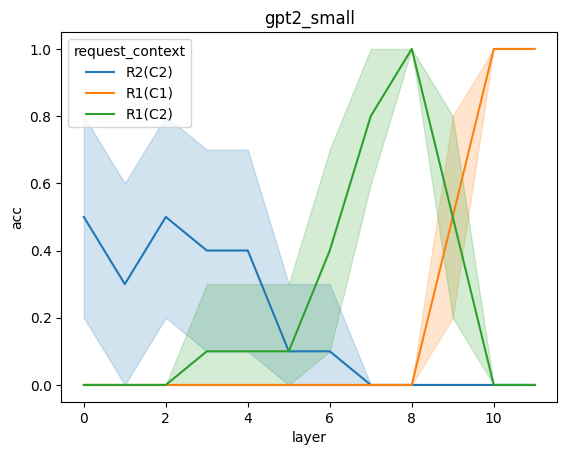

In [39]:
plot_normalized_accuracy(tokens_per_prompt_pair=tokens_per_prompt_pair,
                         model_name='gpt2_small',
                         R2_C2=R2_C2,
                         R1_C2=R1_C2,
                         R1_C1=R1_C1)